In [1]:
from IPython.core.display import HTML

def css_styling():
    styles = open("../src/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
# Generic imports
import numpy as np
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec
from scipy import stats
from scipy.stats import fisher_exact, mannwhitneyu, spearmanr
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm.notebook import tqdm

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [4]:
# Custom import
sys.path.append('../src/')
from Thomas_code import patients, feature_conversion
import flm_tools

The main goal during my masters thesis research was to reduce the number of clinical measurements that would be used in a model of patient trajectories in the ICU. My first approach was to search for measurements that would associate with how favorable the discharge disposition was.  
In that vein, I asked two initial questions:  
1. For numeric measurements (which are the majority), which ones would associate with the favorability of the discharge disposition when looking at their typical visit value?  
2. Knowing that this dataset isn't a random sample of tests, and that doctors are likely following clinical suspicions, which clinical measurements would associate with the favorability of the discharge disposition simply by their presence/absence?

## First, get the data

Let's obtain the main table for this notebook. The first line implements a series of data reading and wrangling procedures that became repetitive throughout my masters. As such, they were all wrapped into this neat line of code.

In [5]:
clean_all_table = flm_tools.get_cleaned_data(version='2021-06-02/210602_digest_including_basic_endpoints_and_sofa')

# At the time, we knew of only a handful of issues regarding units
# This is the one-liner that dealt with those.
clean_all_table = flm_tools.convert_to_standard_units(clean_all_table)

I decided to restrict analysis to patients for which we had adjudication of the pneumonia type (hospital-acquired (HAP), community-acquired (CAP), or ventilator-acquired (VAP) pneumonia). If not, patients were excluded. This decision is unique to this analysis, so I did not place this block within a function.

In [6]:
diagnosis = patients.modified_edw_rc('pneumonia_episode_category_assessment',
                                     revision='2021-06-02/210602_digest_including_basic_endpoints_and_sofa',
                                     columns=['case_number',
                                              'clin_cap_viral_npop',
                                              'pneu_assess_dt',
                                              'pt_category'])

# Shortening the pneumonia category string
diagnosis = feature_conversion.shorten_pt_category(diagnosis)

# Gotta have the category assessed!
diagnosis = diagnosis.dropna(subset=['pt_category'])

# We chose to group HAP and VAP
diagnosis['pt_category'] = diagnosis['pt_category'].replace({'VAP': 'HAP/VAP',
                                                            'HAP': 'HAP/VAP'})

# Patients can transition from one category to another during ICU stay
# However, it always went towards HAP or VAP (which is why we grouped them)
diagnosis = diagnosis.drop_duplicates(subset=['case_number'], keep='last')

clean_all_table = pd.merge(clean_all_table, diagnosis)

In [7]:
# Outputting some general numbers
total_unique_tests = clean_all_table['measurement_concept_name'].nunique()
print(f"These are the number of unique clinical measurements present: {total_unique_tests}")
total_cases = clean_all_table['case_number'].nunique()
print(f"Number of cases/patients with available records and outcomes: {total_cases}")

These are the number of unique clinical measurements present: 541
Number of cases/patients with available records and outcomes: 307


## Question 1: Does the typical value of a numeric clinical test during a patient's hospitalization predict the patient's discharge favorability?  
For each patient and each clinical measurement/test, I determined the typical value using the median and the mean, and used Spearman's rank correlation to measure association of the typical values of a test with the discharge favorability or discharge rank\*. I chose Spearman's correlation rather than Pearson's because it **non-parametrically** quantifies monotonic associations. Also, non-parametric methods have lower false positive rates (i.e. the reject-null-hypothesis rate is lower), which can give more confidence in the robustness of the results (it also demands more of the data).  
  
  \**Intensive-care physicians had previously ranked discharges from 0 to 5, to capture how favorable they were. Zero was expired, five was discharged home.*

In [8]:
# Extracting the strictly numerical tests in the data and cleaning up
a = clean_all_table['value_as_number'].notnull()
num_measure_table = clean_all_table[a]

# Some numerical tests come with ranges (>, <, >=, <=). Deleting those entries.
b = num_measure_table['operator_vocabulary_id'] != 'SNOMED'
num_measure_table = num_measure_table.loc[b].copy()

In [9]:
# Obtaining median value
median_values = num_measure_table.groupby(
    ['case_number',
     'discharge_disposition_name_conv',
     'measurement_concept_code',
     'measurement_concept_name'])['value_as_number'].median().to_frame('median_value').reset_index()

# Obtaining mean value
mean_values = num_measure_table.groupby(
    ['case_number',
     'discharge_disposition_name_conv',
     'measurement_concept_code',
     'measurement_concept_name'])['value_as_number'].mean().to_frame('mean_value').reset_index()


# These lines is take away measurements appearing only once on both pandas dataframes
c = median_values['measurement_concept_name'].value_counts()
median_values = median_values[median_values['measurement_concept_name'].isin(c[c>1].index)]

d = mean_values['measurement_concept_name'].value_counts()
mean_values = mean_values[mean_values['measurement_concept_name'].isin(d[d>1].index)]


# Making the measurements the row indices.
median_values = median_values.set_index('measurement_concept_name')
mean_values = mean_values.set_index('measurement_concept_name')

Implementing Spearman's rank correlation for table with median values

In [10]:
agg_results = []

# Running Spearman on every test separately
for test in tqdm(median_values.index.unique()):
    discharges = median_values.loc[test, 'discharge_disposition_name_conv']
    measurement_values = median_values.loc[test, 'median_value']
    
    rho, pvalue = stats.spearmanr(discharges, measurement_values)
    
    result_summary = {'measurement_name': test,
                      'Corr_values_Spearman': rho,
                      'P_values_Spearman': pvalue,
                      # Implementing Bonferroni correction since there multiple comparisons
                      'Bonferroni_pvalue': np.clip([pvalue*median_values.index.nunique()],
                                                   0,
                                                   1)[0],
                      '#_cases_given_test': len(discharges)}
    
    agg_results.append(result_summary)
    
results = pd.DataFrame(agg_results)
results['%_cases_given_test'] = (results['#_cases_given_test']/total_cases)*100

# Taking away tests without a valid p-value
results_median = results.dropna(subset=['Corr_values_Spearman',
                                        'P_values_Spearman',
                                        'Bonferroni_pvalue']).copy()

# Some tests end up with p-value=0. Dealing with those for log-Bonferroni
e = results_median['Bonferroni_pvalue'] == 0.0
results_median.loc[e, 'log_bonferroni'] = np.inf
results_median.loc[~e,
                   'log_bonferroni'] = -1*np.log10(results_median.loc[~e,
                                                                      'Bonferroni_pvalue'])

  0%|          | 0/342 [00:00<?, ?it/s]

C:\Users\FLM9508\.conda\envs\sam\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Now repeating the above procedure for table with mean values

In [11]:
agg_results = []

# Running Spearman on every test separately
for test in tqdm(mean_values.index.unique()):
    discharges = mean_values.loc[test, 'discharge_disposition_name_conv']
    measurement_values = mean_values.loc[test, 'mean_value']
    
    rho, pvalue = stats.spearmanr(discharges, measurement_values)
    
    result_summary = {'measurement_name': test,
                      'Corr_values_Spearman': rho,
                      'P_values_Spearman': pvalue,
                      # Implementing Bonferroni correction since there multiple comparisons
                      'Bonferroni_pvalue': np.clip([pvalue*mean_values.index.nunique()],
                                                   0,
                                                   1)[0],
                      '#_cases_given_test': len(discharges)}
    
    agg_results.append(result_summary)
    
results = pd.DataFrame(agg_results)
results['%_cases_given_test'] = (results['#_cases_given_test']/total_cases)*100

# Taking away tests without a valid p-value
results_mean = results.dropna(subset=['Corr_values_Spearman',
                                      'P_values_Spearman',
                                      'Bonferroni_pvalue']).copy()

# Some tests end up with p-value=0. Dealing with those for log-Bonferroni
f = results_mean['Bonferroni_pvalue'] == 0.0
results_mean.loc[f, 'log_bonferroni'] = np.inf
results_mean.loc[~f,
                 'log_bonferroni'] = -1*np.log10(results_mean.loc[~f,
                                                                  'Bonferroni_pvalue'])

  0%|          | 0/342 [00:00<?, ?it/s]

Modifying both the median and mean result tables a bit for downstream plotting

In [12]:
# Median
results_median_sig = results_median[results_median.Bonferroni_pvalue < 0.01].copy()
results_median_nonsig = results_median[results_median.Bonferroni_pvalue >= 0.01].copy()
g = results_median_sig['P_values_Spearman'] != 0.0
results_median_sig = results_median_sig.loc[g].copy()
# results_median_sig.sort_values(by='log_bonferroni', ascending=False)

In [13]:
for_annot_median = results_median_sig[results_median_sig.Bonferroni_pvalue < 0.000001]
x_median = list(for_annot_median['Corr_values_Spearman'])
y_median = list(for_annot_median['log_bonferroni'])
text_median = ['Glucose in:\nserum\nurine\nvenous blood',
               'Hematocrit/Serum protein',
               'Glucose in:\nserum\nurine\nvenous blood',
               'Hematocrit/Serum protein',
               'Glucose in:\nserum\nurine\nvenous blood',
               'Lymphocytes/100 leukocytes',
               'Neutrophils/100 leukocytes',
               'Red blood cell count']

In [14]:
# Mean
results_mean_sig = results_mean[results_mean.Bonferroni_pvalue < 0.01]
results_mean_nonsig = results_mean[results_mean.Bonferroni_pvalue >= 0.01]
h = results_mean_sig['P_values_Spearman'] != 0.0
results_mean_sig = results_mean_sig.loc[h]
# results_mean_sig.sort_values(by='log_bonferroni', ascending=False)

In [15]:
for_annot_mean = results_mean_sig[results_mean_sig.Bonferroni_pvalue < 0.000001]
x_mean = list(for_annot_mean['Corr_values_Spearman'])
y_mean = list(for_annot_mean['log_bonferroni'])
text_mean = ['Glucose in:\nserum\nurine\nvenous blood',
             'Serum protein',
             'Glucose in:\nserum\nurine\nvenous blood',
             'Hematocrit',
             'Glucose in:\nserum\nurine\nvenous blood',
             'Lymphocytes/100 leukocytes',
             'Neutrophils/100 leukocytes']

Now comes the plotting

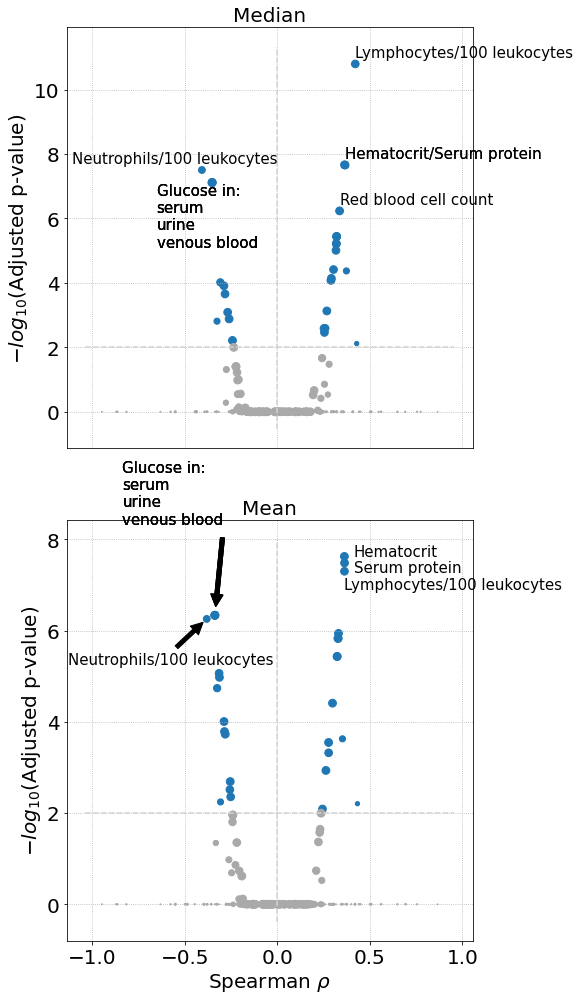

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(8,14))

# Main plotting lines for median values
ax[0].scatter(results_median_sig['Corr_values_Spearman'],
              results_median_sig['log_bonferroni'],
              marker='o',
              s=results_median_sig['#_cases_given_test']/5)
ax[0].scatter(results_median_nonsig['Corr_values_Spearman'],
              results_median_nonsig['log_bonferroni'],
              marker='o',
              s=results_median_nonsig['#_cases_given_test']/5,
              c='darkgray')

# Various graph-annotating lines for median values
ax[0].set_ylabel(r"$-log_{10}$(Adjusted p-value)", fontsize=20)
ax[0].vlines(0, ax[0].get_ylim()[0],
             ax[0].get_ylim()[-1], color='lightgrey',
             linestyles='dashed')
ax[0].hlines(-1*np.log10(0.01), ax[0].get_xlim()[0],
             ax[0].get_xlim()[-1], color='lightgrey',
             linestyles='dashed')
# ax[0].set_xlabel(r"Spearman $\rho$", fontsize=20)
ax[0].tick_params(bottom=False, labelbottom=False)
ax[0].tick_params(axis='x', labelsize=20)
ax[0].tick_params(axis='y', labelsize=20)
ax[0].set_title('Median', fontsize=20)
ax[0].grid(linestyle=':')

# Now annotating specific tests on the median graph
for i in range(0, len(x_median)):
    if x_median[i] < 0:
        if text_median[i] == 'Glucose in:\nserum\nurine\nvenous blood':
            ax[0].annotate(text_median[i],
                           (x_median[i]-0.3, y_median[i]-2),
                           fontsize=15)
        else:
            ax[0].annotate(text_median[i],
                           (x_median[i]-0.7, y_median[i]+0.2),
                           fontsize=15)
    else:
        ax[0].annotate(text_median[i],
                       (x_median[i], y_median[i]+0.2),
                       fontsize=15)

        
# Main plotting lines for mean values
ax[1].scatter(results_mean_sig['Corr_values_Spearman'],
              results_mean_sig['log_bonferroni'],
              marker='o',
              s=results_mean_sig['#_cases_given_test']/5)
ax[1].scatter(results_mean_nonsig['Corr_values_Spearman'],
              results_mean_nonsig['log_bonferroni'],
              marker='o',
              s=results_mean_nonsig['#_cases_given_test']/5,
              c='darkgray')

# Various graph-annotating lines for mean values
ax[1].set_xlabel(r"Spearman $\rho$", fontsize=20)
ax[1].set_ylabel(r"$-log_{10}$(Adjusted p-value)", fontsize=20)
ax[1].vlines(0, ax[1].get_ylim()[0],
             ax[1].get_ylim()[-1], color='lightgrey',
             linestyles='dashed')
ax[1].hlines(-1*np.log10(0.01), ax[1].get_xlim()[0],
             ax[1].get_xlim()[-1], color='lightgrey',
             linestyles='dashed')
ax[1].tick_params(axis='x', labelsize=20)
ax[1].tick_params(axis='y', labelsize=20)
ax[1].set_title('Mean', fontsize=20)
ax[1].grid(linestyle=':')

# Now annotating specific tests on the mean graph
for j in range(0,len(x_mean)):
    if x_mean[j] < 0:
        if text_mean[j] == 'Glucose in:\nserum\nurine\nvenous blood':
            ax[1].annotate(text_mean[j],
                           xy=(x_mean[j], y_mean[j]),
                           xytext=(x_mean[j]-0.5, y_mean[j]+2),
                           fontsize=15,
                           arrowprops=dict(facecolor='black', shrink=0.1))
        else:
            ax[1].annotate(text_mean[j],
                           xy=(x_mean[j], y_mean[j]),
                           xytext=(x_mean[j]-0.75, y_mean[j]-1),
                           fontsize=15,
                           arrowprops=dict(facecolor='black', shrink=0.1))
        
    elif text_mean[j] == 'Lymphocytes/100 leukocytes':
        ax[1].annotate(text_mean[j],
                       (x_mean[j], y_mean[j]-0.4),
                       fontsize=15)
        
    elif text_mean[j] == 'Serum protein':
        ax[1].annotate(text_mean[j],
                       (x_mean[j]+0.05, y_mean[j]-0.2),
                       fontsize=15)
        
    else:
        ax[1].annotate(text_mean[j],
                       (x_mean[j]+0.05, y_mean[j]),
                       fontsize=15)

plt.tight_layout()

Yes! Using the median or the mean to obtain a "typical" value doesn't drastically change which tests associate with the dicharge rank.  
  
  When also looking at the generated results dataframes, I found that many laboratory tests that are used in ICU severity scores (APACHE, SOFA) also appear strongly associated with discharge ranks, which gave me and my group confidence in the validity of the analysis. But this analysis found other tests as well!  
  
  What was surprising to see was both lymphocyte and neutrophil counts on opposite sides of the volcano plots above. When talking about this with clinicians within and outside our lab, their consensus was that while both counts should be expected to go up when a patient has an active infection, they hint at different infectious processes. In general, clinicians pointed to neutrophil counts being better associated with bacterial infections, and lymphocyte counts, to acute viral infections. Since bacterial infections have higher case fatality rates (in general), that might explain the results above. But even as important, things like myocardial infarctions or leukemia can also increase neutrophil counts, which can explain results even further.

## Question 2: Does the presence/absence of a clinical test during a patient's hospitalization predict the patient's discharge favorability?  
EHR is not designed to serve as a research data repository, but rather as a record of clinical-decision making. Because of that, we at the lab thought that clinician suspicions of particular conditions afflicting patients would show in the form of some tests being proxies for severe conditions (and perhaps proxies for milder forms of disease as well). As such, I collected the discharge ranks of patients who received a particular clinical measurement, and the discharge ranks of those who did not receive the measurement. I then used a Mann-Whitney U test to compare the medians of both discharge rank distributions. Alternatively, I also used a method prevalent in gene expression analysis, where I asked which clinical measurements would be enriched in patients who expire vs. those who survive. I did this using Fisher’s exact test of the null hypothesis that observed proportions for both patient groups were identical. Finally, I repeated both analyses for every measurement in the record, and Bonferroni-adjusted due to multiple comparisons. Again, I chose conservative, non-parametric statistical techniques for increased robustness.

In [17]:
# Since we're assessing presence/absence, we can dismiss values
measurements_in_encounter = clean_all_table[['case_number',
                                             'measurement_concept_code',
                                             'measurement_concept_name',
                                             'discharge_disposition_name_conv']].drop_duplicates()

Main code block that performs the Mann-Whitney U test analysis

In [18]:
agg = []

# Create a pandas series keyed by case_number, returning the specific outcome of that case
outcomes = clean_all_table[['case_number',
                            'discharge_disposition_name_conv']].drop_duplicates()
outcome_by_patient = outcomes.set_index('case_number',
                                        verify_integrity=True)['discharge_disposition_name_conv']

# For each measurement in the table
for test in tqdm(measurements_in_encounter['measurement_concept_name'].unique()):
    
    # First, get an array of True/False to flag rows containing the test we'd like to analyze
    k = measurements_in_encounter['measurement_concept_name'] == test
    
    # Now getting the case_numbers (patients) who got the test into a list. This is necessary for later.
    posit_ids = list(measurements_in_encounter.loc[k, 'case_number'])
    
    # Now gather the outcome of each of the patients who got the test
    posit_out = outcome_by_patient[posit_ids]

    # And the outcome of those who didn't get the test
    negat_out = outcome_by_patient[~outcome_by_patient.index.isin(posit_ids)]
    
    # Finally, if at least one patient received, and did not receive the test,
    if len(posit_out) != 0 and len(negat_out) != 0:
        # evaluate Mann-Whitney on both outcome lists
        _, pvaluemw = stats.mannwhitneyu(posit_out,
                                         negat_out,
                                         alternative='two-sided')
    else:
        continue
        
    # And gather results in a row of a table
    result_summary = {'measurement_name': test,
                      'median_present': np.median(posit_out),
#                       'IQR_present': stats.iqr(posit_out),
                      'median_absent': np.median(negat_out),
#                       'IQR_absent': stats.iqr(negat_out),
                      'p_values_MannWhitney': pvaluemw,
                      'bonferroni_pvalues': np.clip([pvaluemw*measurements_in_encounter['measurement_concept_name'].nunique()],
                                                    0,
                                                    1)[0],
                      'cases_given_test': len(posit_out),
                      'fraction_patients': len(posit_out)/total_cases}
    
    agg.append(result_summary)
    
results_mw = pd.DataFrame(agg)
results_mw['delta_median'] = results_mw['median_present'] - results_mw['median_absent']

  0%|          | 0/541 [00:00<?, ?it/s]

Now, let's also see which tests are enriched in patients who expire as a result of their illness (either in the ICU, or sent to hospice care), and which tests are enriched in patients who survive. Using Fisher's exact test, as it is ideal for contingency tables.

In [19]:
# For Fisher's exact test, we needed binary discharges.
# That means repeating data reading lines
clean_all_table = flm_tools.get_cleaned_data(version='2021-06-02/210602_digest_including_basic_endpoints_and_sofa',
                                             outcome_encoding='binary')
diagnosis = patients.modified_edw_rc('pneumonia_episode_category_assessment',
                                     revision='2021-06-02/210602_digest_including_basic_endpoints_and_sofa',
                                     columns=['case_number',
                                              'clin_cap_viral_npop',
                                              'pneu_assess_dt',
                                              'pt_category'])
diagnosis = feature_conversion.shorten_pt_category(diagnosis)
diagnosis = diagnosis.dropna(subset=['pt_category'])
diagnosis['pt_category'] = diagnosis['pt_category'].replace({'VAP': 'HAP/VAP',
                                                            'HAP': 'HAP/VAP'})
diagnosis = diagnosis.drop_duplicates(subset=['case_number'], keep='last')
clean_all_table = pd.merge(clean_all_table, diagnosis)

outcomes = clean_all_table[['case_number',
                            'discharge_disposition_name_conv']].drop_duplicates()

In [20]:
# We need outcomes as boolean variables for Fisher's exact test
outcomes['discharge_disposition_name_conv'] = outcomes['discharge_disposition_name_conv'].astype(bool)

# Custom-made function requirement for Fisher's exact test
category_in_annotation = ['survived_in_measurement', 'expired_in_measurement']
category_not_in_annotation = ['survived_not_in_measurement', 'expired_not_in_measurement']

fisher_enrichment = flm_tools.enrichment(outcomes,
                                         clean_all_table,
                                         'case_number',
                                         'discharge_disposition_name_conv',
                                         'measurement_concept_name',
                                         category_in_annotation,
                                         category_not_in_annotation)

The following are processing steps for plotting. First, processing for Mann-Whitney analysis.

In [21]:
filtered_mw = results_mw.dropna()
filtered_mw.loc[:,'log_bonferroni'] = -1*np.log10(filtered_mw['bonferroni_pvalues'])
filtered_mw_sig = filtered_mw.loc[filtered_mw.bonferroni_pvalues < 0.01]
filtered_mw_nonsig = filtered_mw.loc[filtered_mw.bonferroni_pvalues >= 0.01]

In [22]:
text_mw = ["aPPT in Platelet poor plasma", "Calcium.ionized in Blood",
           "Fibrinogen in Platelet poor plasma", "Burr cells in Blood",
           "Haptoglobin in Serum"]

Next, Fisher's exact test

In [23]:
l = fisher_enrichment['log_bonferroni'] >= 2
l_increase = fisher_enrichment['ratio'] > 0

for m in fisher_enrichment[l].index:
    if fisher_enrichment.loc[m,
                             'measurement_concept_name'] == 'Amikacin [Mass/volume] in Serum or Plasma':
        fisher_enrichment.loc[m,
                              'measurement_concept_name'] = 'Amikacin in Serum'
        
    elif fisher_enrichment.loc[m,
                               'measurement_concept_name'] == 'Burr cells [Presence] in Blood by Light microscopy':
        fisher_enrichment.loc[m,
                              'measurement_concept_name'] = 'Burr cells in Blood'
        
    else:
        fisher_enrichment.loc[m,
                              'measurement_concept_name'] = 'Fibrinogen in Platelet poor plasma'

Plotting!

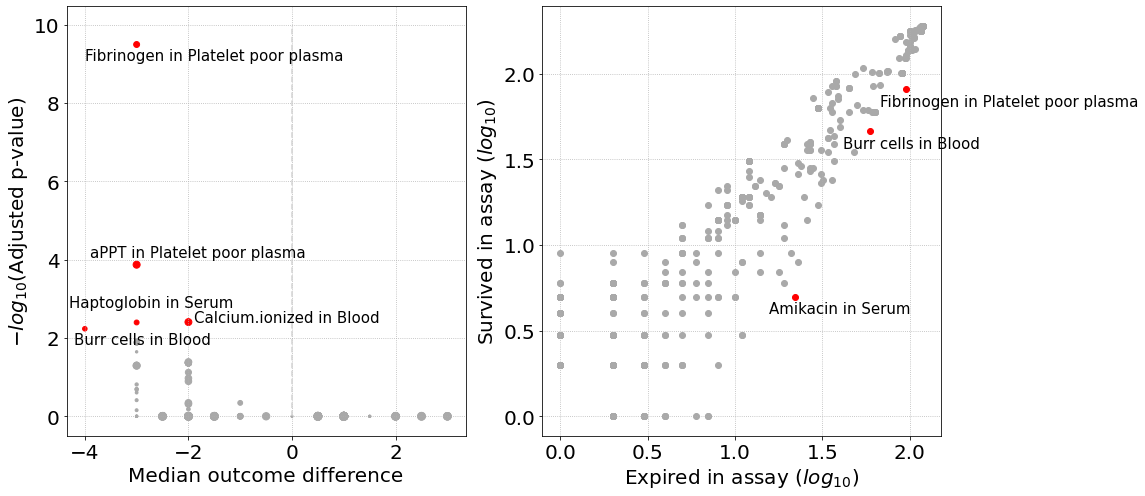

In [24]:
fig1,ax1 = plt.subplots(ncols=2, nrows=1, figsize=(16,7))

# Main plotting lines for Mann-Whitney
ax1[0].scatter(filtered_mw_sig['delta_median'],
               filtered_mw_sig['log_bonferroni'],
               marker='o',
               s=filtered_mw_sig['cases_given_test']/5,
               c='r')
ax1[0].scatter(filtered_mw_nonsig['delta_median'],
               filtered_mw_nonsig['log_bonferroni'],
               marker='o',
               s=filtered_mw_nonsig['cases_given_test']/5,
               c='darkgray')

# Various graph-annotating lines for Mann-Whitney
ax1[0].set_xlabel("Median outcome difference", fontsize=20)
ax1[0].set_ylabel(r"$-log_{10}$(Adjusted p-value)", fontsize=20)
ax1[0].tick_params(axis='x', labelsize=20)
ax1[0].tick_params(axis='y', labelsize=20)
ax1[0].vlines(0, 0, ax1[0].get_ylim()[-1],
              color='lightgrey', linestyles='dashed')
ax1[0].grid(linestyle=':')
ax1[0].set_title('Mann-Whitney U-test', fontsize=20)

# Now annotating specific tests on the Mann-Whitney graph
x = list(filtered_mw_sig['delta_median'])
y = list(filtered_mw_sig['log_bonferroni'])

for n in range(0,len(x)):
    if text_mw[n] == "Fibrinogen in Platelet poor plasma":
        ax1[0].annotate(text_mw[n],
                        (x[n]-1, y[n]-0.4),
                        fontsize=15)
        
    elif text_mw[n] == "Calcium.ionized in Blood":
        ax1[0].annotate(text_mw[n],
                        (x[n]+0.1, y[n]),
                        fontsize=15)
        
    elif text_mw[n] == "Haptoglobin in Serum":
        ax1[0].annotate(text_mw[n],
                        (x[n]-1.3, y[n]+0.4),
                        fontsize=15)
        
    elif text_mw[n] == "Burr cells in Blood":
        ax1[0].annotate(text_mw[n],
                        (x[n]-0.2, y[n]-0.4),
                        fontsize=15)
        
    else:
        ax1[0].annotate(text_mw[n],
                        (x[n]-0.9, y[n]+0.2),
                        fontsize=15)

        
# Main plotting lines for Fisher's exact test
ax1[1].scatter(np.log10(fisher_enrichment.loc[~l,
                                              'expired_in_measurement'] + 1),
               np.log10(fisher_enrichment.loc[~l,
                                              'survived_in_measurement'] + 1),
               c='darkgray')
ax1[1].scatter(np.log10(fisher_enrichment.loc[l & l_increase,
                                              'expired_in_measurement'] + 1),
               np.log10(fisher_enrichment.loc[l & l_increase,
                                              'survived_in_measurement'] + 1),
               c='blue')
ax1[1].scatter(np.log10(fisher_enrichment.loc[l & ~l_increase,
                                              'expired_in_measurement'] + 1),
               np.log10(fisher_enrichment.loc[l & ~l_increase,
                                              'survived_in_measurement'] + 1),
               c='r')

# Now annotating specific tests on the Fisher's exact test's graph
for o in fisher_enrichment[l].index:
    ax1[1].text(np.log10(fisher_enrichment.loc[o,
                                               'expired_in_measurement'] + 1) - 0.15,
                np.log10(fisher_enrichment.loc[o,
                                               'survived_in_measurement'] + 1) - 0.1,
                fisher_enrichment.loc[o,
                                      'measurement_concept_name'],
                fontsize=15)
    
# Various graph-annotating lines for Fisher's exact test
ax1[1].set_xlabel(r"Expired in assay ($log_{10}$)", fontsize=20)
ax1[1].set_ylabel(r"Survived in assay ($log_{10}$)", fontsize=20)
ax1[1].tick_params(axis='x', labelsize=20)
ax1[1].tick_params(axis='y', labelsize=20)
ax1[1].grid(linestyle=':')
ax1[1].set_title('Enrichment analysis', fontsize=20)

plt.tight_layout()

These are interesting!  
Talking to clinicians, I learned that these clinical measurements are indeed indicators of poor clinical courses. In general, they seem to point to coagulopathies, or blood-clotting disorders.

In [25]:
# # This is to plot a histogram of number of patients receiving tests
# fig1, ax1 = plt.subplots(1,1,figsize=(14,8), constrained_layout=True)
# ax1.hist(second_results['fraction_patients'], bins=10, edgecolor='k')
# ax1.set_xlabel('Fraction of patients',fontsize=25)
# ax1.set_ylabel('Number of distinct assays',fontsize=25)
# ax1.tick_params(axis='x', labelsize=23)
# ax1.tick_params(axis='y', labelsize=23)
# ax1.grid(linestyle=':')
# # ax1.text(0.01, 0.99, 'b', transform=ax1.transAxes,
# #       fontsize=25, va='top')
# # plt.savefig(figure_output_directory+"testdistribution_210602.png")